# Generative Adversarial Networks

This is an simple example of how GANs perform implicit distribution learning. Most examples focus on learning to generate complex examples such as faces. However, we can choose a simple example and show how GANs are essentially just a procedure which tries to learn to (approximately) sample from a target distribution. 

In this notebook, I show how we can use GANs to learn to sample from a correlated normal distribution. 

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns; sns.set(style="white", color_codes=True)
%matplotlib inline

In [2]:
class Generator(torch.nn.Module):
    def __init__(self, in_features, out_features):
        super(Generator, self).__init__()
        self.l1_size = 100
        self.l2_size = 100
        self.relu = torch.nn.ReLU()
        self.l1 = torch.nn.Linear(in_features, self.l1_size)
        self.l2 = torch.nn.Linear(self.l1_size, self.l2_size)
        self.l3 = torch.nn.Linear(self.l2_size, out_features)
        
    def forward(self,z):
        
        a1 = self.relu(self.l1(z))
        a2 = self.relu(self.l2(a1))
        a3 = self.l3(a2)
        return a3
    
    
class Discriminator(torch.nn.Module):
    def __init__(self, in_features, out_features):
        super(Discriminator, self).__init__()
        self.l1_size = 100
        self.l2_size = 100
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()
        self.l1 = torch.nn.Linear(in_features, self.l1_size)
        self.l2 = torch.nn.Linear(self.l1_size, self.l2_size)
        self.l3 = torch.nn.Linear(self.l2_size, out_features)
        
    def forward(self, x):
        a1 = self.relu(self.l1(x))
        a2 = self.relu(self.l2(a1))
        a3 = self.l3(a2)
        return a3
    
    def forward_with_sigmoid(self, x):
        return self.sigmoid(self.forward(x))

In [9]:
cov = 0.2*np.eye(2)+0.8
x_real = np.random.multivariate_normal(np.ones(2)*5, cov, size=2000)

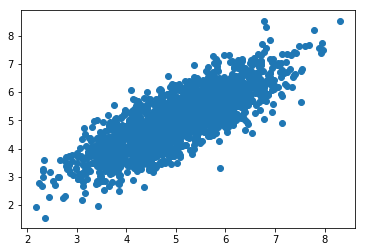

In [10]:
plt.scatter(x_real[:, 0], x_real[:,1])

In [24]:
G = Generator(2,2)
D = Discriminator(2,1)
G_opt = torch.optim.Adam(G.parameters(), lr=0.001)
D_opt = torch.optim.Adam(D.parameters(), lr=0.001)

x_t_real = torch.from_numpy(x_real).float()
#y = torch.from_numpy(np.concatenate([np.zeros(2000), np.ones(2000)])).float().reshape(-1,1)
for i in tqdm(range(8000)):
    for i in range(5):
        ind = np.arange(x_real.shape[0])
        mask = np.random.choice(ind, 50)
        x_real_batch = torch.from_numpy(x_real[mask]).float()

        z = torch.from_numpy(np.random.normal(size=x_real_batch.shape)).float()
        x_fake = G.forward(z)
        X = torch.cat([x_fake, x_real_batch])
        y_hat = D.forward(X)
        y = torch.from_numpy(
            np.concatenate([np.zeros((x_real_batch.shape[0],1)), np.ones((x_real_batch.shape[0],1))])).float()
        
        G_opt.zero_grad()
        D_opt.zero_grad()
        Dloss = torch.nn.functional.binary_cross_entropy_with_logits(y_hat, y)
        Dloss.backward()
        D_opt.step()
    
    
    z = torch.from_numpy(np.random.normal(size=x_real_batch.shape)).float()
    x_fake = G.forward(z)
    y_hat = D.forward(x_fake)
    
    D_opt.zero_grad()
    G_opt.zero_grad()
    Gloss = torch.nn.functional.binary_cross_entropy_with_logits(y_hat, torch.ones_like(y_hat))
    Gloss.backward()
    G_opt.step()

100%|██████████| 8000/8000 [01:03<00:00, 125.97it/s]


In [25]:
z = torch.from_numpy(np.random.normal(size=(2000,2))).float()
x_fake = G.forward(z).data.numpy()

In [26]:
x_fake[:5]

array([[ 5.728724  ,  4.1457305 ],
       [ 5.40456152,  4.45151711],
       [ 4.84720278,  4.71813679],
       [ 4.63672686,  5.75195694],
       [ 6.61752272,  6.6394043 ]], dtype=float32)

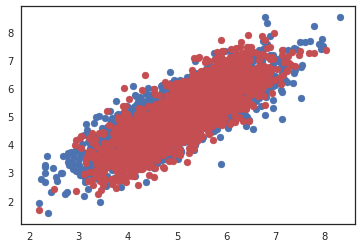

In [27]:
plt.scatter(x_real[:, 0], x_real[:,1])
plt.scatter(x_fake[:,0], x_fake[:,1], c='r')

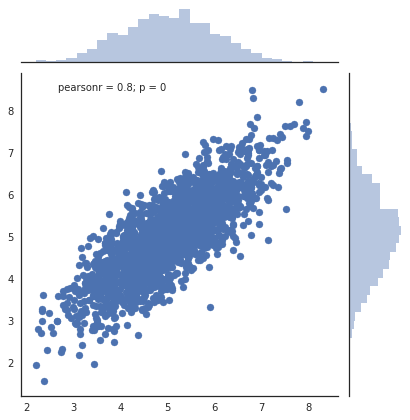

In [28]:
sns.jointplot(x_real[:,0], x_real[:,1])

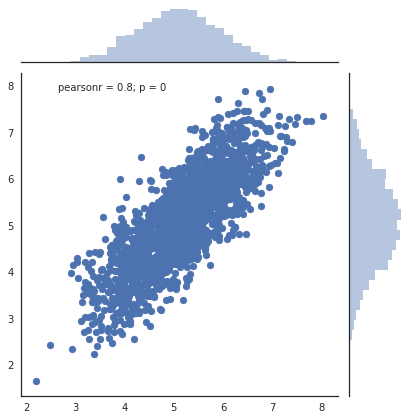

In [29]:
sns.jointplot(x_fake[:,0], x_fake[:,1])

# Summary

This simple example shows how GANs learn implicit distributions - they learn how to sample from a distribution, even if they don't provide its form. This simple example was learning points that are from a correlated gaussian, but the concept is exactly the same when learning faces or other more complex samples - a GAN is learning an implicit distribution of the data.